# Bayesian Model Selection for Gaussian Processes (using marginal likelihood)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
import scipy

## Generate a synthetic dataset

In [2]:
# Generate sinusoidal data
np.random.seed(200)
x = np.random.uniform(low=-10, high=10, size=50)
x = np.sort(x)

# Generate t, with random Gaussian noise
t = np.sin(x/1.5)
e = np.random.normal(size=t.shape[0], scale=0.1)
t = t + e

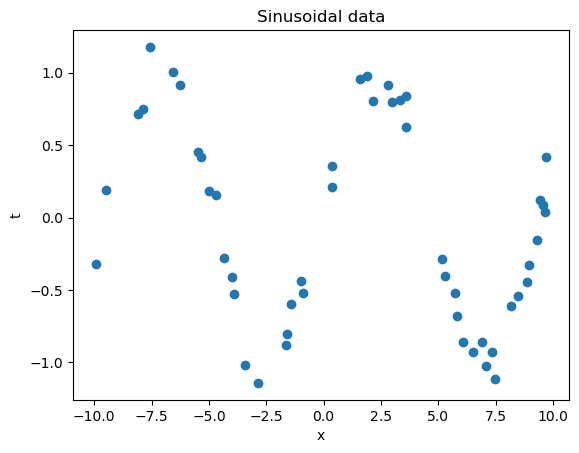

In [3]:
# Plot x and t
plt.scatter(x, t)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sinusoidal data')
plt.show()

## Implementing vanilla Gaussian Process with RBF kernel

In [4]:
def gaussian_process_regression(X, Y, noise_var, length_scale, test_points):
    """
    Calculate the Gaussian Process prediction
    :param X: inputs
    :param y: targets
    :param noise_var: noise level
    :param length_scale: length_scale of RBF kernel
    :param test_point: test input
    :return: mean and variance of the prediction
    """
    # Create RBF kernel with length scale
    rbf = RBF(length_scale=length_scale)
    
    # Calculate the covariance matrix
    K = rbf.__call__(X.reshape(-1, 1))

    # Perform Cholesky factorization of K + noise_var * I
    L = np.linalg.cholesky(K + noise_var * np.eye(K.shape[0]))

    # Calculate alpha
    beta = scipy.linalg.solve_triangular(L, Y, lower=True)
    alpha = scipy.linalg.solve_triangular(L.T, beta, lower=False)

    # Calculate the mean and variance of each test points
    means = []
    vars = []
    for test_point in test_points:
        k_star = rbf.__call__(np.array([test_point]).reshape(-1, 1), X.reshape(-1, 1)).reshape(-1)
        mean_f = np.dot(k_star, alpha)

        # Calculate the variance
        v = scipy.linalg.solve_triangular(L, k_star.reshape(-1), lower=True)
        var_f = (rbf.__call__(np.array([test_point]).reshape(-1, 1), np.array([test_point]).reshape(-1, 1))
                 - np.dot(v, v))[0][0]

        # Append to the mean and variance
        means.append(mean_f)
        vars.append(var_f)

    # Return the mean and variance
    return np.array(means), np.array(vars)

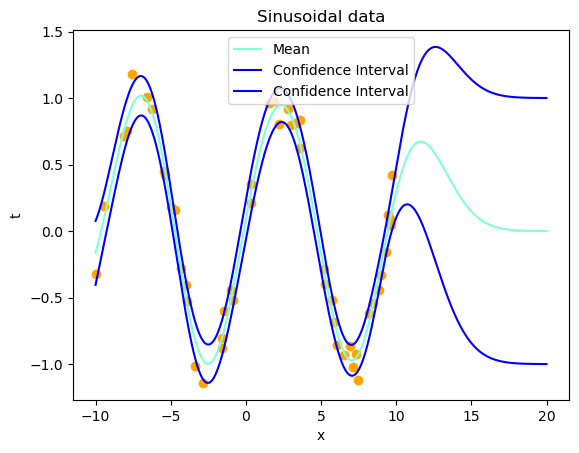

In [5]:
# For the train set
X_test = np.arange(-10, 20, 0.01)
mean_f, var_f = gaussian_process_regression(x, t, 0.1, 2.42, X_test)

# Draw the training points, means and variances
plt.plot(X_test, mean_f, color='aquamarine', label='Mean')
plt.plot(X_test, mean_f - np.sqrt(var_f), color='blue', label='Confidence Interval')
plt.plot(X_test, mean_f + np.sqrt(var_f), color='blue', label='Confidence Interval')
plt.scatter(x, t, color='orange')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Sinusoidal data')
plt.legend()
plt.savefig('figures/sinusoidal.png')
plt.show()

## Implementing Bayesian model selection with marginal likelihood

In [9]:
def evaluate_log_likelihood(x_train, y_train, length_scale, noise_var):
    """
    Evaluate the marginal log likelihood (evidence) of the current model
    :param x_train: the training features
    :param y_train: the training labels
    :param length_scale: the length-scale parameter of the RBF covariance function
    :param noise_var: sigma^2 - the variance of the noise
    :return: the current marginal log likelihood (evidence)
    """
    # Get the number of data points
    N = y_train.shape[0]
    
    # Calculate the covariance_matrix
    rbf = RBF(length_scale=length_scale)
    covariance_matrix = rbf.__call__(x_train.reshape(-1, 1))
    
    # Calculate K_y
    k_y = covariance_matrix + noise_var * np.eye(covariance_matrix.shape[0])
    
    # Calculate the eigenvalues of k_y
    eigenvalues, _ = np.linalg.eig(k_y)
    
    # Calculate the marginal log likelihood
    marginal_log_likelihood = (N / 2) * np.log(2 * np.pi) + (1/2) * np.sum(np.log(eigenvalues)) \
        + (1/2) * np.dot(y_train, np.linalg.solve(k_y, y_train))
    return marginal_log_likelihood
    
    
def evaluate_log_marginal_likelihood_gradient(x_train, y_train, length_scale, noise_var):
    """
    Evaluate the gradient of the marginal log-likelihood (evidence) of the current model w.r.t the length-scale
    :param x_train: the training features
    :param y_train: the training labels
    :param length_scale: the length-scale parameters of the RBF covariance function
    :param noise_var: sigma^2 - the variance of the noise
    :return: the gradient of the current marginal log-likelihood w.r.t the length scale parameter
    """
    # Calculate the covariance_matrix
    rbf = RBF(length_scale=length_scale)
    covariance_matrix, d_k_length_scale = rbf.__call__(x_train.reshape(-1, 1), eval_gradient=True)
    
    # Calculate K_y
    k_y = covariance_matrix + noise_var * np.eye(covariance_matrix.shape[0])
    
    # Find the inverse of k_y
    k_y_inv = np.linalg.inv(k_y)
    
    # Calculate the gradient of K w.r.t to l
    # d_k_length_scale = (covariance_matrix * ((x_train.reshape(-1, 1) - x_train.reshape(1, -1)) ** 2)) / (length_scale ** 3)
    
    # Calculate alpha
    alpha = k_y_inv @ y_train
    
    # Calculate the gradient of marginal log likelihood w.r.t the length scale
    d_length_scale = (1/2) * np.trace((alpha @ alpha.T - k_y_inv) @ d_k_length_scale[0])
    return d_length_scale


def find_appropriate_length_scale(x_train, y_train, noise_var, learning_rate=0.01, epochs=100):
    """
    Find the appropriate length scale that maximize the evidence
    :param x_train: the training features
    :param y_train: the training labels
    :param noise_var: sigma^2 - the variance of the noise
    :param learning_rate: the learning rate for gradient ascent
    :param epochs: the number of epochs
    :return: the appropriate length scale
    """
    # Initialise length scale
    length_scale = 1
    
    # Update length_scale
    best_loss = float('inf')
    best_length_scale = None
    
    for epoch in range(epochs):
        # Calculate the log likelihood 
        log_likelihood = evaluate_log_likelihood(x_train, y_train, length_scale, noise_var)
        
        # Calculate the gradient w.r.t the length scale
        d_length_scale = evaluate_log_marginal_likelihood_gradient(x_train, y_train, length_scale, noise_var)
        
        # Save the length scale
        if log_likelihood < best_loss:
            best_loss = log_likelihood
            best_length_scale = length_scale
        
        # Update length scale
        length_scale += learning_rate * d_length_scale
        
        # Display the marginal log-likelihood
        print(f"EPOCH {epoch}, LOG LIKELIHOOD {log_likelihood}")
        
    return best_length_scale

In [10]:
# Find the appropriate length scale
length_scale = find_appropriate_length_scale(x, t, noise_var=1, learning_rate=0.00001, epochs=100000)
print(f"BEST LENGTH SCALE IS {length_scale}")

EPOCH 0, LOG LIKELIHOOD 58.32391138149015
EPOCH 1, LOG LIKELIHOOD 58.32386008816917
EPOCH 2, LOG LIKELIHOOD 58.32380879469065
EPOCH 3, LOG LIKELIHOOD 58.323757501054665
EPOCH 4, LOG LIKELIHOOD 58.323706207261196
EPOCH 5, LOG LIKELIHOOD 58.323654913310264
EPOCH 6, LOG LIKELIHOOD 58.323603619201904
EPOCH 7, LOG LIKELIHOOD 58.323552324936124
EPOCH 8, LOG LIKELIHOOD 58.32350103051296
EPOCH 9, LOG LIKELIHOOD 58.32344973593237
EPOCH 10, LOG LIKELIHOOD 58.32339844119443
EPOCH 11, LOG LIKELIHOOD 58.32334714629917
EPOCH 12, LOG LIKELIHOOD 58.323295851246556
EPOCH 13, LOG LIKELIHOOD 58.32324455603667
EPOCH 14, LOG LIKELIHOOD 58.32319326066947
EPOCH 15, LOG LIKELIHOOD 58.323141965145005
EPOCH 16, LOG LIKELIHOOD 58.323090669463284
EPOCH 17, LOG LIKELIHOOD 58.32303937362433
EPOCH 18, LOG LIKELIHOOD 58.32298807762818
EPOCH 19, LOG LIKELIHOOD 58.32293678147482
EPOCH 20, LOG LIKELIHOOD 58.32288548516428
EPOCH 21, LOG LIKELIHOOD 58.322834188696596
EPOCH 22, LOG LIKELIHOOD 58.32278289207175
EPOCH 23, LO